In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import itertools
sns.set_theme()
sns.set_style('whitegrid')

def get_raw_results(cur_dir, skip=0, till=-1):
    with open(cur_dir, 'r') as file:
        elems = file.read().split('\n')[skip:till]
        elems = [float(e) for e in elems]
        return elems

def results_generator(l, basedir, skip=0, till=-1, raw=False):
    for d in l:
        cur_dir = os.path.join(basedir, d)
        elems = get_raw_results(cur_dir, skip, till)
        if raw:
            yield elems
        else:
            m = sum(elems) / len(elems)
            yield m

In [3]:
def make_gemm_graph(ax, basedir, title, show_caches=True):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_remote_hbm_remote_hbm')]
    numerical.sort()
    numerical = numerical[::]
    l = [str(dir) for dir in numerical]

    memories = [
        'ddr',
        'hbm',
        'ddr_remote',
        'hbm_remote',
    ]
    formats = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']


    results = [(list(results_generator(l, basedir + f'/{a}_{b}_{c}', skip=1)), f'{a}*{b}={c}') for a, b, c in itertools.product(memories, memories, ['hbm'])]

    ax.set_xscale('log', base=2)
    ax.set_title(title)
    ax.set_xlabel('Per matrix size (bytes)')
    ax.set_ylabel('Throughput to out matrix (GB/s)')
    for (r, l), f in zip(results, formats):
        ax.plot(numerical, r, f, label=l)
    if show_caches:
        ax.axvline(x=65536, ls=':', label = 'CPU L1')
        ax.axvline(x=1048576, ls='-.', label = 'CPU L2')
        ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
        ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    #ax.legend(title='Memory type')

def make_gemm_heatmap(ax, basedir, title, dest_memory, xlabel='', ylabel='', yticklabels=True, xticklabels=True):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_remote_hbm_remote_hbm')]
    numerical.sort()
    print(numerical[-1])

    l = [str(dir) for dir in numerical]

    memories = [
        'hbm',
        'ddr',
        'hbm_remote',
        'ddr_remote',
    ]

    labels = ['HBM', 'DDR', 'HBM-p', 'DDR-p']

    data = np.zeros((4, 4))

    for i in range(4):
        for j in range(4):
            try:
                data[i, j] = list(results_generator(l, basedir + f'/{memories[i]}_{memories[j]}_{dest_memory}', skip=1))[-1]
            except:
                pass

    data /= 1000
    if yticklabels:
        yticklabels = labels
    else:
        yticklabels = []
    if xticklabels:
        xticklabels = labels
    else:
        xticklabels = []
    sns.heatmap(data, annot=True, fmt='.1f', xticklabels=xticklabels, yticklabels=yticklabels, linewidths=1, square=False, cmap='Greens', ax=ax, cbar=False)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

def make_read_write_graph(ax, basedir, title, scalability=False, n_threads=1, rng=None, latency=False, show_caches=True, show_cpu=True, show_gpu=True, remote=False, skip=1):
    if remote:
        numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_remote')]
    else:
        numerical = [int(dir) for dir in os.listdir(basedir + '/hbm')]
    numerical.sort()
    if rng is not None:
        numerical = numerical[rng[0]:rng[1]]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr', skip=skip))
    results2 = list(results_generator(l, basedir + '/hbm', skip=skip))
    if remote:
        results3 = list(results_generator(l, basedir + '/ddr_remote', skip=skip))
        results4 = list(results_generator(l, basedir + '/hbm_remote', skip=skip))
    #results3 = list(results_generator(l, basedir + '/mmio', skip=0, till=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        ax.set_xlabel('Num threads/blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    if latency:
        ax.set_ylabel('Latency (ns)')
    else:
        ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR')
    ax.plot(numerical, results2, 'x', label='HBM')
    if remote:
        ax.plot(numerical, results3, 's', label='DDR-r')
        ax.plot(numerical, results4, '^', label='HBM-r')
    #ax.plot(numerical, results3, '.', label='MMIO')
    if not scalability and show_caches:
        if show_cpu:
            if n_threads > 1:
                ax.axvline(x=65536*n_threads, linestyle=(0, (1, 10)), label = f'CPU L1 x {n_threads}')
                ax.axvline(x=1048576*n_threads, linestyle=(0, (3, 10, 1, 10)), label = f'CPU L2 x {n_threads}')
            ax.axvline(x=65536, ls=':', label = f'CPU L1')
            ax.axvline(x=1048576, ls='-.', label = f'CPU L2')
            ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        if show_gpu:
            ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
            ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type', fontsize=8)

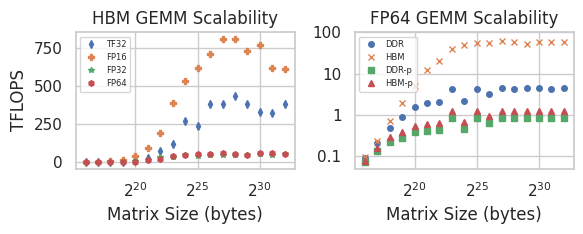

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5))
numerical = [int(dir) for dir in os.listdir('results/apps/gemm/cublas/half/hbm_remote_hbm_remote_hbm')]
numerical.sort()
numerical = numerical[8::2]
l = [str(dir) for dir in numerical]
types = ['tf32', 'half', 'float', 'double']
labels = ['TF32', 'FP16', 'FP32', 'FP64']
markers = ['o', 'x', 's', '^']
x = [i for i in numerical for _ in range(8)]
def myplot(ax):
    for t, m, label in zip(types,  ['d', 'P','*','h'], labels):
        res = [i/1000 for i in results_generator(l, f'results/apps/gemm/cublas/{t}/hbm_hbm_hbm', skip=2, raw=False)]
        ax.plot(numerical, res, m, label=label, ms=4)
    ax.set_xscale('log', base=2)
    ax.set_ylabel("TFLOPS")
    ax.set_xlabel("Matrix Size (bytes)")
    ax.legend(fontsize=6)
    ax.set_title("HBM GEMM Scalability")
myplot(ax1)
def myplot(ax):
    for t, m, label in zip(['ddr','hbm','ddr_remote','hbm_remote'], markers, ['DDR','HBM','DDR-p','HBM-p']):
        res = [i/1000 for i in results_generator(l, f'results/apps/gemm/cublas/double/{t}_{t}_hbm', skip=2, raw=False)]
        ax.plot(numerical, res, m, label=label, ms=4)
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=10)
    ax.set_yticks([0.1, 1, 10, 100])
    from matplotlib.ticker import ScalarFormatter
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_yticklabels(['0.1','1','10','100'])
    # ax.set_ylabel("TFLOPS")
    ax.set_xlabel("Matrix Size (bytes)")
    ax.legend(fontsize=6)
    ax.set_title("FP64 GEMM Scalability")
myplot(ax2)
plt.tight_layout()
fig.savefig("gemm_scalability.pdf", bbox_inches='tight')
# make_gemm_graph(ax, 'results/apps/gemm/cublas/half', '')

4293404046
4293404046
4293404046
4293404046


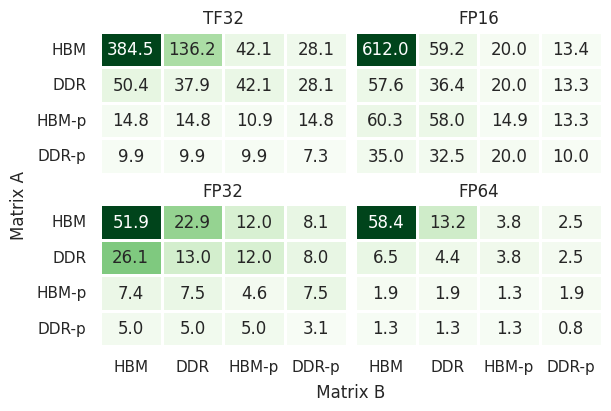

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 4), layout='constrained')
make_gemm_heatmap(ax1, 'results/apps/gemm/cublas/tf32', "TF32", 'hbm', xticklabels=False)
make_gemm_heatmap(ax2, 'results/apps/gemm/cublas/half', "FP16", 'hbm', yticklabels=False, xticklabels=False)
make_gemm_heatmap(ax3, 'results/apps/gemm/cublas/float', "FP32", 'hbm')
make_gemm_heatmap(ax4, 'results/apps/gemm/cublas/double', "FP64", 'hbm', yticklabels=False)
fig.supxlabel("                 Matrix B", fontsize=12)
fig.supylabel("Matrix A", fontsize=12)
fig.savefig("gemm.pdf", bbox_inches='tight')

4294967296


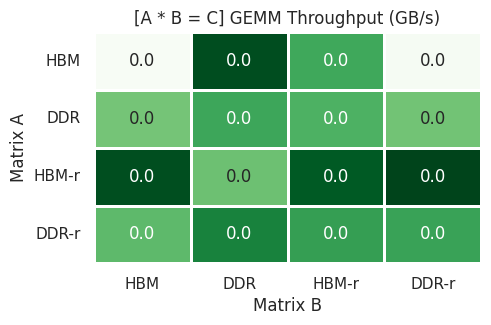

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
fig.set_dpi(100)
make_gemm_heatmap(ax, 'results/apps/gemm/openblas/', "[A * B = C] GEMM Throughput (GB/s)", 'ddr')
#make_gemm_heatmap(ax2, 'results/apps/gemm/cublas/', "[A * B = C] GEMM Throughput (GB/s), to ddr_remote", 'ddr_remote')

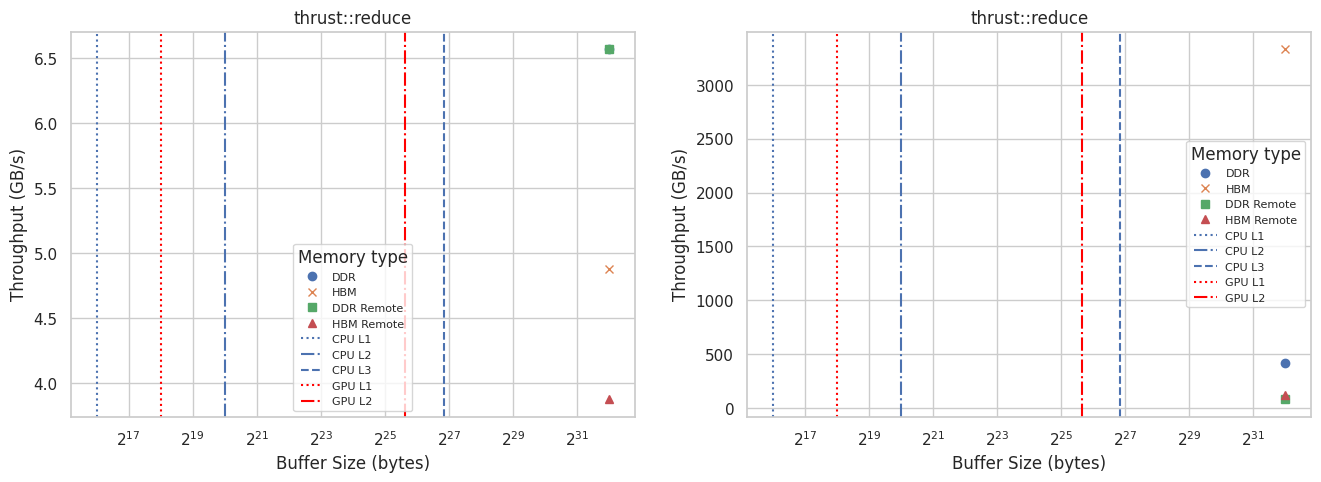

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
make_read_write_graph(ax1, 'results/apps/reduce/host', 'thrust::reduce', remote=True)
make_read_write_graph(ax2, 'results/apps/reduce/device', 'thrust::reduce', remote=True)

In [52]:
def get_osu_data(test, skip=4):
    with open(f'results/osu/{test}') as file:
        d = file.read()
        d = d.split('\n')[skip:-1]
        x = [int(p.split(' ')[0]) for p in d]
        d = [float(p.split(' ')[-1]) for p in d]

        return x, d

def get_osu_last(test):
    x, d = get_osu_data(test)
    return d[-1]

def plot_collective(ax, test, title):
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=2)
    ax.set_xlabel('Buffer size')
    ax.set_ylabel('Latency (us)')
    ax.set_title(title)

    x, d = get_osu_data(test)
    ax.plot(x, d, 'o', label='DDR')
    x, d = get_osu_data(f'{test}_cuda')
    ax.plot(x, d, 'x', label='HBM')
    ax.legend()

def plot_collective_scalability(ax, test, title):
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=2)
    ax.set_xlabel('Ranks')
    ax.set_ylabel('Latency (us)')
    ax.set_title(title)
    from matplotlib.ticker import ScalarFormatter
    ax.xaxis.set_major_formatter(ScalarFormatter())

    x = []
    d1 = []
    d2 = []
    i = 2
    while i <= 128:
        x.append(i)
        d1.append(get_osu_last(f'{test}_{i}'))
        d2.append(get_osu_last(f'{test}_{i}_cuda'))
        i = i * 2

    ax.plot(x, d1, 'o', label='DDR')
    ax.plot(x, d2, 'x', label='HBM')
    ax.set_xticks(x)
    ax.legend()

def plot_onesided(ax, test, title):
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=2)
    ax.set_xlabel('Buffer size')
    ax.set_ylabel('Latency (us)')
    ax.set_title(title)

    x, d = get_osu_data(test, 6)
    ax.plot(x, d, 'o', label='DDR')
    x, d = get_osu_data(f'{test}_cuda', 7)
    ax.plot(x, d, 'x', label='HBM')
    ax.legend()

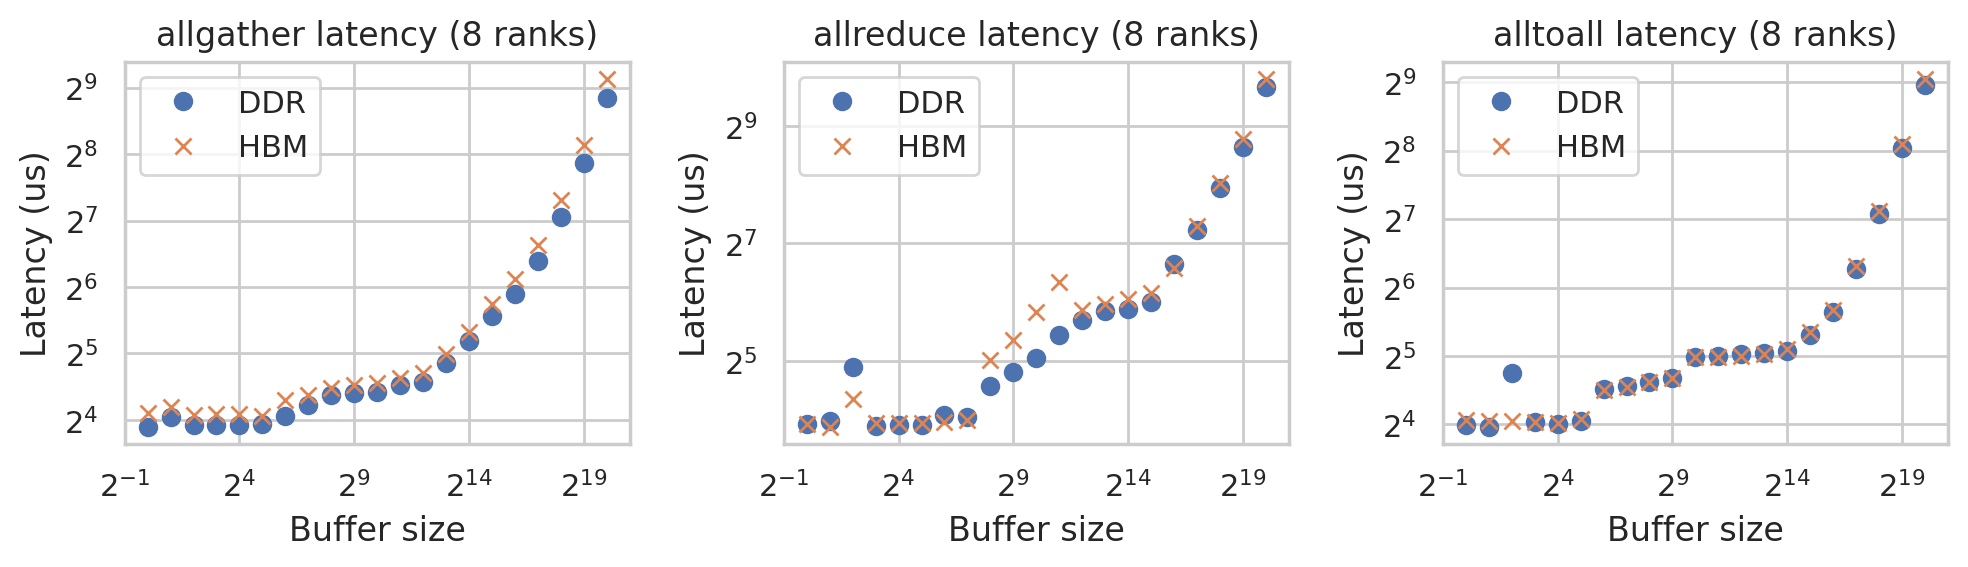

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

ranks = 8
plot_collective(ax1, f'osu_allgather_{ranks}', f'allgather latency ({ranks} ranks)')
plot_collective(ax2, f'osu_allreduce_{ranks}', f'allreduce latency ({ranks} ranks)')
plot_collective(ax3, f'osu_alltoall_{ranks}', f'alltoall latency ({ranks} ranks)')
fig.set_dpi(200)
fig.tight_layout()

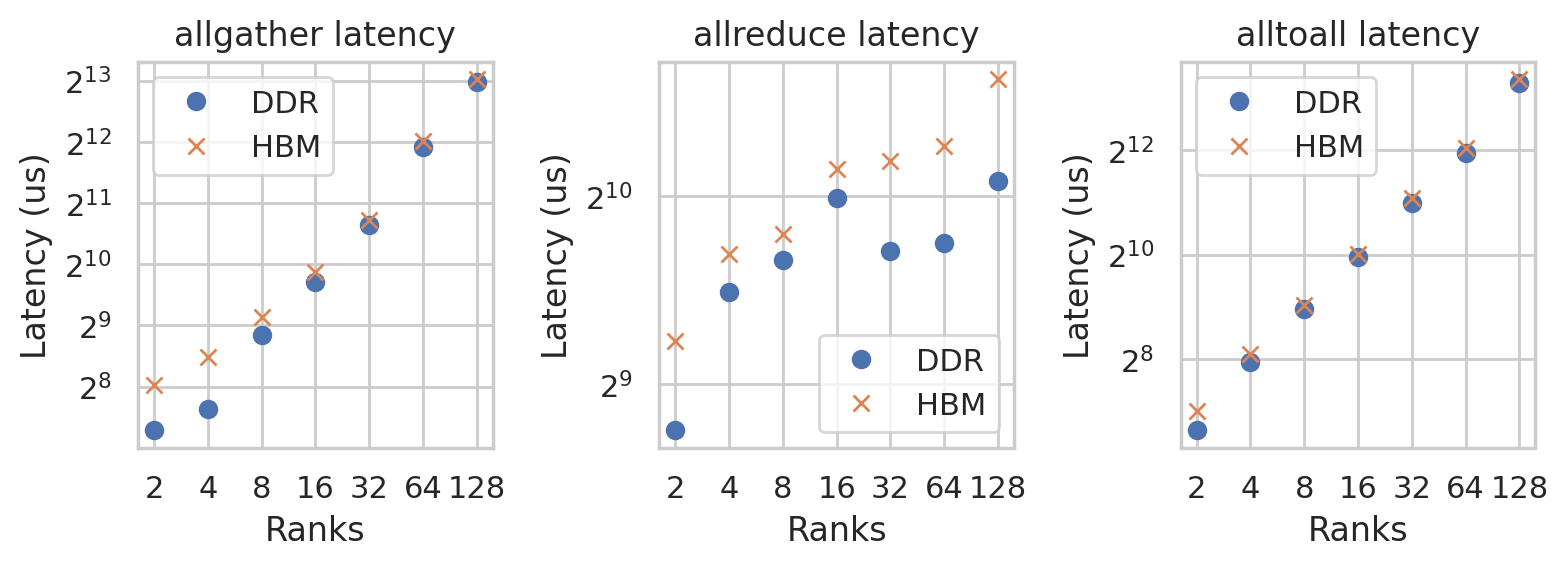

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))

plot_collective_scalability(ax1, 'osu_allgather', 'allgather latency')
plot_collective_scalability(ax2, 'osu_allreduce', 'allreduce latency')
plot_collective_scalability(ax3, 'osu_alltoall', 'alltoall latency')

fig.set_dpi(200)
fig.tight_layout()

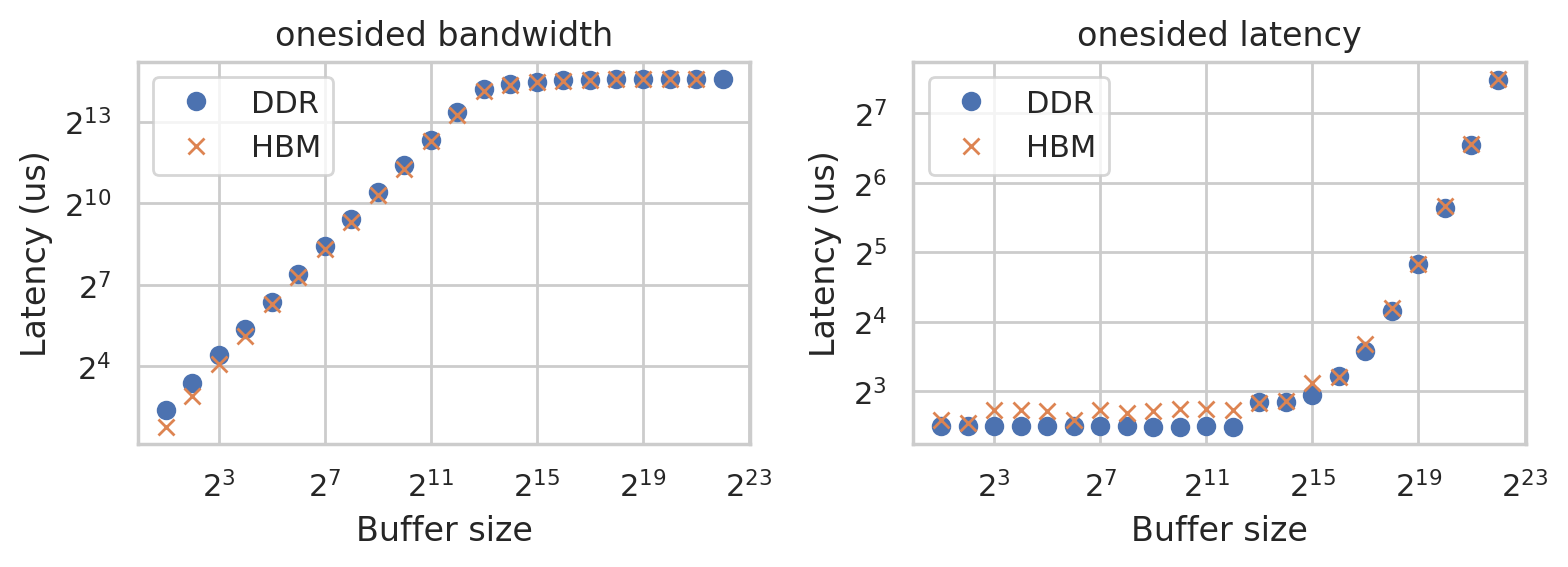

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

plot_onesided(ax1, 'osu_get_bw', 'onesided bandwidth')
plot_onesided(ax2, 'osu_get_latency', 'onesided latency')

fig.set_dpi(200)
fig.tight_layout()

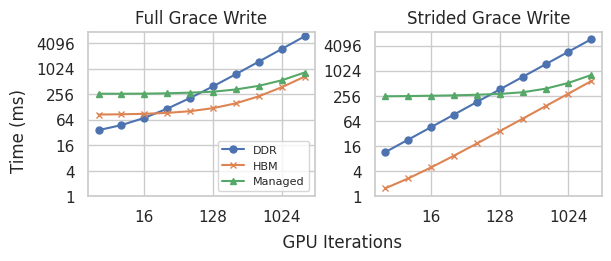

In [4]:
def make_copy_graph(ax, basedir, title, ms=3, legend=True):
    numerical = [int(dir) for dir in os.listdir(basedir + '/managed')]
    numerical.sort()
    numerical = numerical[2:]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr', skip=1))
    results2 = list(results_generator(l, basedir + '/hbm', skip=1))
    results3 = list(results_generator(l, basedir + '/managed', skip=1))

    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=2)
    ax.set_title(title)
    # ax.set_xlabel('GPU full writes')
    # ax.set_ylabel('Time (ms)')
    ax.plot(numerical, results1, 'o-', ms=ms, label='DDR')
    ax.plot(numerical, results2, 'x-', ms=ms, label='HBM')
    ax.plot(numerical, results3, '^-', ms=ms, label='Managed')
    from matplotlib.ticker import ScalarFormatter
    ax.set_yticks([1, 4, 16, 64, 256, 1024, 4096])
    ax.set_yticks([1, 4, 16, 64, 256, 1024, 4096])
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    if legend:
        ax.legend(title='', fontsize=8, loc='lower right')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5), layout='constrained')
make_copy_graph(ax1, 'results/apps/transfer/scalability/', 'Full Grace Write', ms=5)
make_copy_graph(ax2, 'results/apps/transfer/pagelevel_scalability/', 'Strided Grace Write', ms=5, legend=False)
fig.supxlabel("              GPU Iterations", fontsize=12)
fig.supylabel("Time (ms)", fontsize=12)
fig.savefig("managed_app.pdf", bbox_inches='tight')

/tmp/ipykernel_54270/1370778320.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
/tmp/ipykernel_54270/1370778320.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


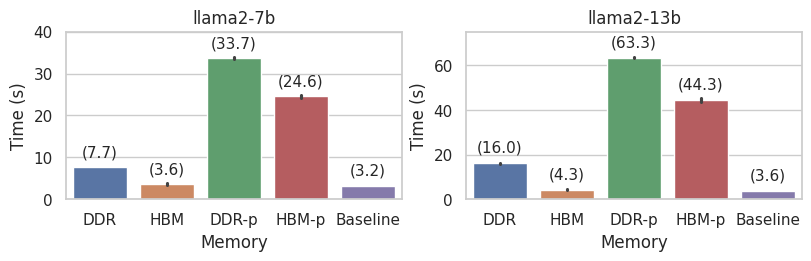

In [20]:
# experiments_cpu = ['fine/host/ddr', 'fine/host/ddr_remote', 'fine/host/hbm', 'fine/host/hbm_remote']
# experiments_gpu = ['fine/device/ddr', 'fine/device/hbm_remote', 'fine/device/hbm', 'fine/device/ddr_remote']
# labels = ['DDR', 'DDR-r', 'HBM', 'HBM-r']
experiments = [0, 4, 1, 12, 'baseline']
labels = ['DDR', 'HBM', 'DDR-p', 'HBM-p', 'Baseline']
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 2.5), layout="constrained")

def myplot(ax, model, delta, title):
    data = {}

    for e, l in zip(experiments, labels):
        with open(f'results/llama/{model}/{e}', 'r') as file:
            elems = file.read().split('\n')[1:-1]
            elems = [float(e) for e in elems]
            elems.sort()
            # elems = elems[1:]
            data[l] = elems

    sns.barplot(data, ax=ax)
    # ax.set_yticks([0,5,10,15,20,25,30,35,40])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_ylabel("Time (s)")
    ax.set_xlabel("Memory")
    ax.set_title(title)
    xposlist = range(len(experiments))
    means = [sum(data[i]) / len(data[i]) for i in labels]
    yposlist = list(means)
    for i in range(len(xposlist)):
        ax.text(xposlist[i], yposlist[i] + delta, '({:.1f})'.format(means[i]), ha='center', fontsize=11, rotation=0)

myplot(ax, 7, 2.5, 'llama2-7b')
myplot(ax2, 13, 5, 'llama2-13b')
ax.set_ylim([0, 40])
ax2.set_ylim([0, 75])
fig.savefig("llama.pdf", bbox_inches='tight')

In [18]:
mem = pd.read_csv('results/llama/13/mem', header=None)

In [19]:
mem[0].max(), mem[2].max()

(168571639, 52585889792)